# **\[SOLAR\]** EPT_RGCN COMPARE MODEL

JiyunLim  
2023-07-22

-   ref:
    <https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/root.html>

# <font color='green'>1. GConvGRU</font>

## Import

In [4]:
# modules 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import eptstgcn
import eptstgcn.planner
import torch_geometric_temporal
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
import mplcyberpunk

# torch
import torch
import torch.nn.functional as F
#import torch_geometric_temporal
from torch_geometric_temporal.nn.recurrent import GConvGRU

# read data
def makedict(FX,W=None,node_ids=None):
    T,N = np.array(FX).shape
    if W==None:
        W = pd.DataFrame(FX).corr().to_numpy().reshape(-1).tolist() # corr 로 weights
    if node_ids==None:
        node_ids = ['node'+str(n) for n in range(N)]
    _dict={
        'edges':[[i,j] for i in range(N) for j in range(N)], 
        'node_ids': node_ids,
        'weights':W,
        'FX':FX
    }
    return _dict

class Loader(object):
    def __init__(self, data_dict):
        self._dataset = data_dict
    
    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        # self._edge_weights = np.array(self._dataset["weights"]).T
        edge_weights = np.array(self._dataset["weights"]).T
        #scaled_edge_weights = minmaxscaler(edge_weights)
        self._edge_weights = edge_weights

    def _get_targets_and_features(self):
        stacked_target = np.stack(self._dataset["FX"])
        self.features = np.stack([
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])
        self.targets = np.stack([
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])


    def get_dataset(self, lags: int = 4) -> StaticGraphTemporalSignal:
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        dataset.node_ids = self._dataset['node_ids']
        return dataset


class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

class RGCN_Learner:
    def __init__(self,train_dataset,dataset_name = None):
        self.train_dataset = train_dataset
        self.lags = torch.tensor(train_dataset.features).shape[-1]
        self.dataset_name = str(train_dataset) if dataset_name is None else dataset_name
        self.method = 'RecurrentGCN'
    def learn(self,filters=32,epoch=50):
        self.model = RecurrentGCN(node_features=self.lags, filters=filters)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.model.train()
        for e in range(epoch):
            for t, snapshot in enumerate(self.train_dataset):
                yt_hat = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
                cost = torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                cost.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            print('{}/{}'.format(e+1,epoch),end='\r')
        # recording HP
        self.nof_filters = filters
        self.epochs = epoch
    def __call__(self,dataset):
        X = torch.tensor(dataset.features).float()
        y = torch.tensor(dataset.targets).float()
        yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr) for snapshot in dataset]).detach().squeeze().float()
        return {'X':X, 'y':y, 'yhat':yhat} 

# learn 
def rgcn(FX,train_ratio,lags,filters,epoch):
    dct = makedict(FX=FX.tolist())
    loader = Loader(dct)
    dataset = loader.get_dataset(lags=lags)
    dataset_tr, dataset_test = eptstgcn.utils.temporal_signal_split(dataset, train_ratio = train_ratio)
    lrnr = RGCN_Learner(dataset_tr, dataset_name = 'org & arbitrary')
    lrnr.learn(filters=filters, epoch=epoch)
    yhat = np.array(lrnr(dataset)['yhat'])
    yhat = np.concatenate([np.array([list(yhat[0])]*lags),yhat],axis=0)
    return yhat

## Load data

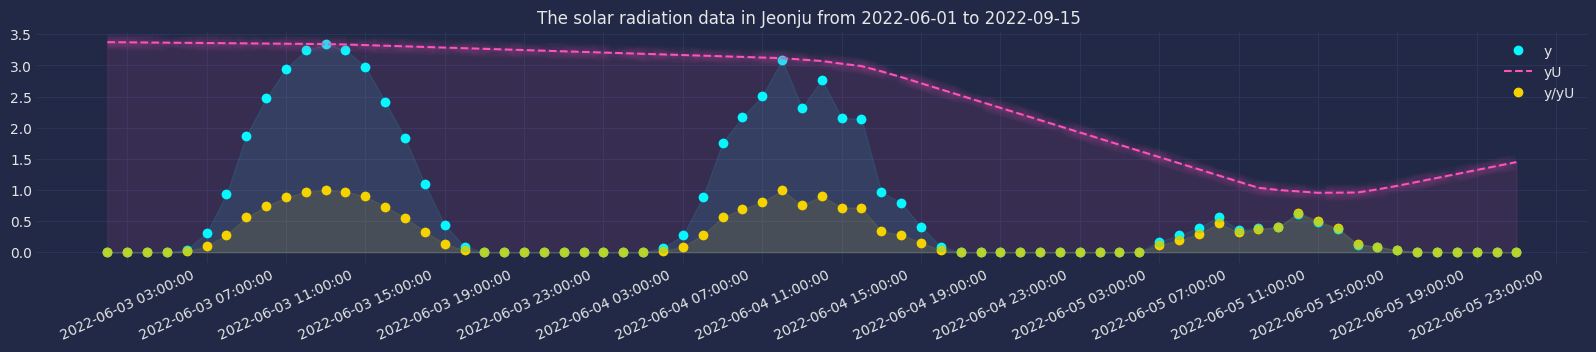

In [13]:
# read dataframe 
df = pd.read_csv('data_eng_230710.csv')

# make y, y_upper, y_period, time, regions 
y = df.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
yU = df.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
yP = np.divide(y, yU+1e-10)
t = df.loc[:,'date']
regions = list(df.loc[:,'Bukchoncheon':'Gyeongju-si'].columns)

# plot rawdata 
start = 50 
end = 50+24*3
city = 19 # 광주 
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(t[start:end],y[start:end,city],'o',label='y')
    plt.plot(t[start:end],yU[start:end,city],'--',label='yU')
    plt.plot(t[start:end],yP[start:end,city],'o',label='y/yU')
    tick_interval = 4
    plt.xticks(range(1, len(t) + 1, tick_interval),rotation=25)        
    plt.legend()
    plt.title("The solar radiation data in {} from {} to {} ".format(regions[city],t.to_list()[0][:10],t.to_list()[-1][:10]))
    mplcyberpunk.add_glow_effects()    # 음영

## Learn

`-` y $\to$ yhat

In [60]:
class RGCN_Learner:
    def __init__(self,train_dataset,dataset_name = None):
        self.train_dataset = train_dataset
        self.lags = torch.tensor(train_dataset.features).shape[-1]
        self.dataset_name = str(train_dataset) if dataset_name is None else dataset_name
        self.method = 'RecurrentGCN'
    def learn(self,filters=32,epoch=50):
        self.model = RecurrentGCN(node_features=self.lags, filters=filters)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.model.train()
        for e in range(epoch):
            for t, snapshot in enumerate(self.train_dataset):
                yt_hat = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
                cost = torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                cost.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            print('{}/{}'.format(e+1,epoch),end='\r')
        # recording HP
        self.nof_filters = filters
        self.epochs = epoch
    def __call__(self,dataset):
        X = torch.tensor(dataset.features).float()
        y = torch.tensor(dataset.targets).float()
        yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr) for snapshot in dataset]).detach().squeeze().float()
        return {'X':X, 'y':y, 'yhat':yhat} 
    
# learn 
def rgcn(FX,train_ratio,lags,filters,epoch):
    dct = makedict(FX=FX.tolist())
    loader = Loader(dct)
    dataset = loader.get_dataset(lags=lags)
    dataset_tr, dataset_test = eptstgcn.utils.temporal_signal_split(dataset, train_ratio = train_ratio)
    lrnr = RGCN_Learner(dataset_tr, dataset_name = 'org & arbitrary')
    lrnr.learn(filters=filters, epoch=epoch)
    yhat = np.array(lrnr(dataset)['yhat'])
    yhat = np.concatenate([np.array([list(yhat[0])]*lags),yhat],axis=0)
    return yhat

In [61]:
# hyper params
LAGS = 4
FILTERS = 4
EPOCH = 10

# global params
TRAIN_RATIO = 0.8
T,N = len(t),len(regions) 
LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
LEN_TR = T - LEN_TEST

In [30]:
# 방법1
yhat = rgcn(y,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)
yhat[yhat < 0]= 0 

10/10

In [31]:
# 방법2 
yUhat = rgcn(yU,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)

yPhat = rgcn(yP,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)
yPhat[yPhat < 0] =0

10/10

In [32]:
classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))


total_mse(classic): 0.0545
total_mse(proposed): 0.0521



total_mse(classic): 0.0545
total_mse(proposed): 0.0521


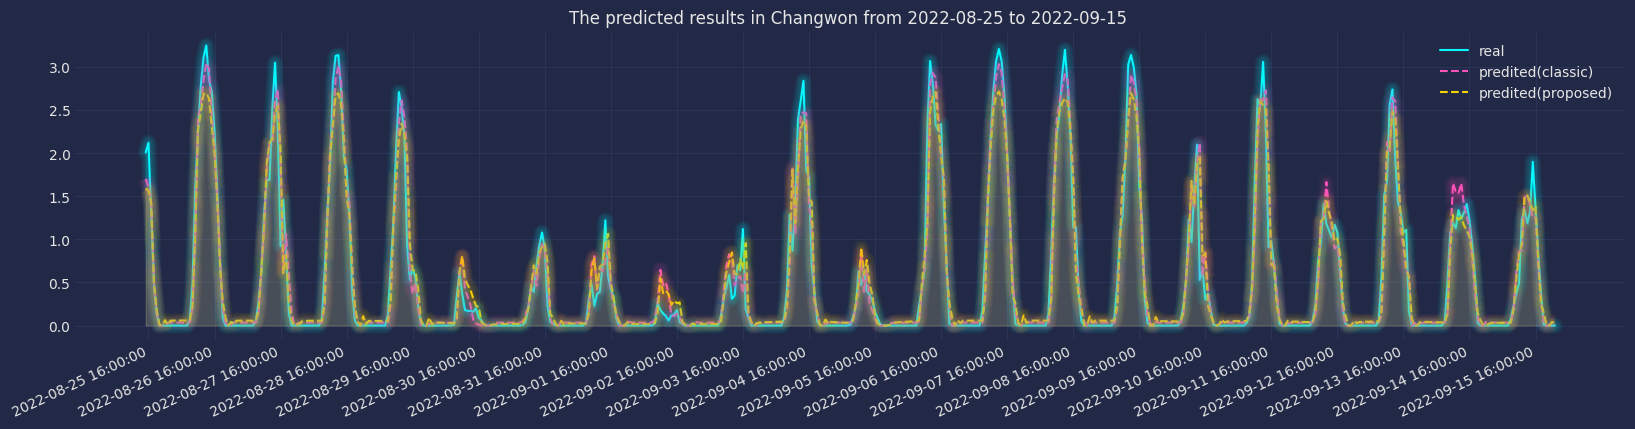

In [33]:
# plot 
start = LEN_TR 
end = LEN_TR + LEN_TEST 
city = 20
tick_interval = 24 

classic = (y - yhat)[start:end, :] ** 2
proposed = (y - yUhat*yPhat)[start:end, :] ** 2

print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 4]  # [가로 크기, 세로 크기]
    plt.plot(t[start:end],y[start:end,city],'-',label='real')
    plt.plot(t[start:end],yhat[start:end,city],'--',label='predited(classic)')
    plt.plot(t[start:end],(yUhat*yPhat)[start:end,city],'--',label='predited(proposed)')
    plt.xticks(range(1, len(t[start:end]) + 1, tick_interval),rotation=25,ha='right')
    plt.title("The predicted results in {} from {} to {} ".format(regions[city],t[start:end].to_list()[0][:10],t[start:end].to_list()[-1][:10]))    
    plt.legend()
    mplcyberpunk.add_glow_effects()

## Analyze

`-` y vs yhat

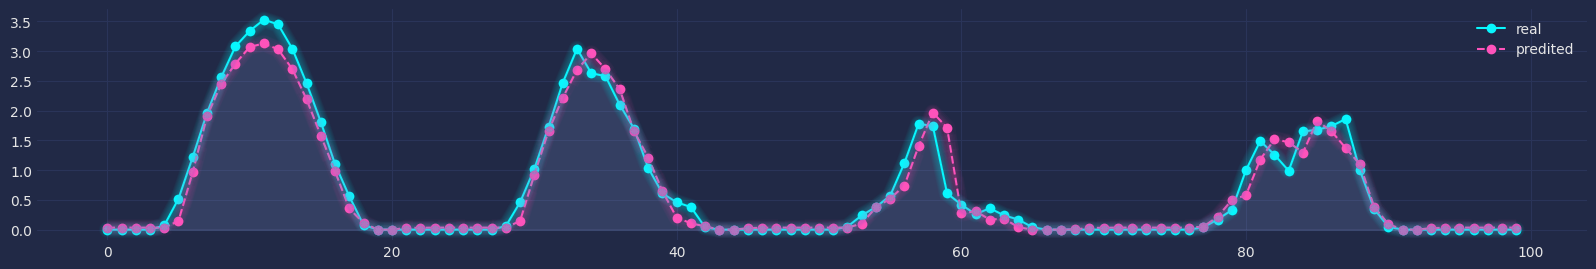

In [34]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot(yhat[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()

`-` yU vs yUhat

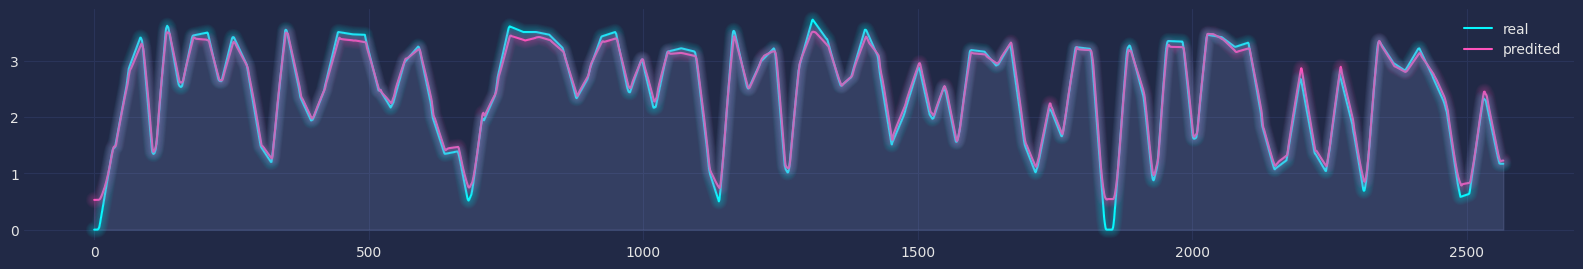

In [35]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yU[:,25],label='real')
    plt.plot(yUhat[:,25],label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` yP vs yPhat

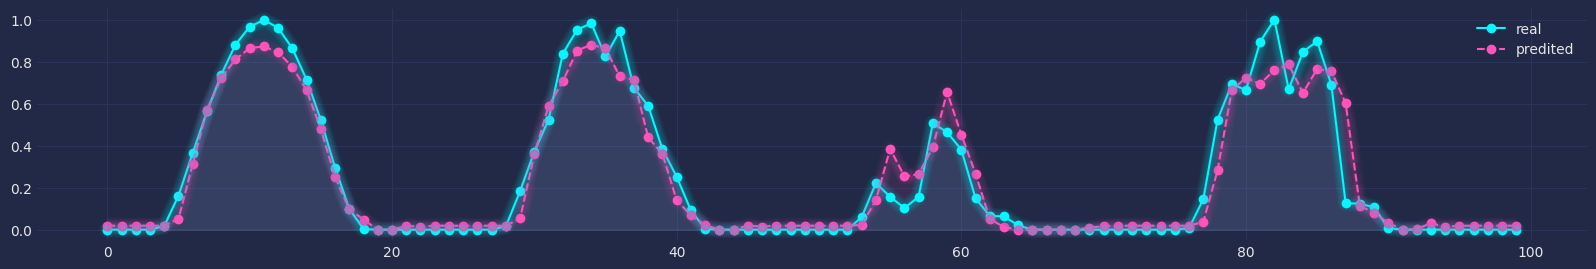

In [36]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yP[50:150,city],'o-',label='real')
    plt.plot(yPhat[50:150,city],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` y vs (yUhat\*yPhat)

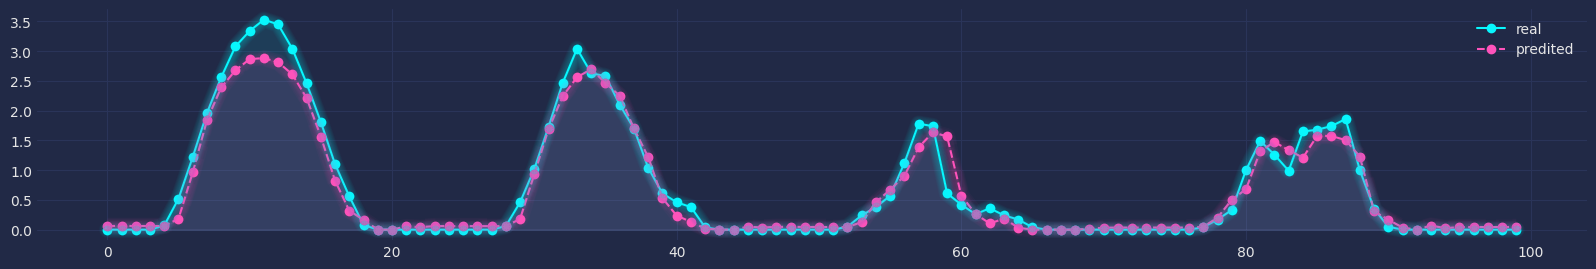

In [37]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot((yUhat*yPhat)[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` 지역별분석

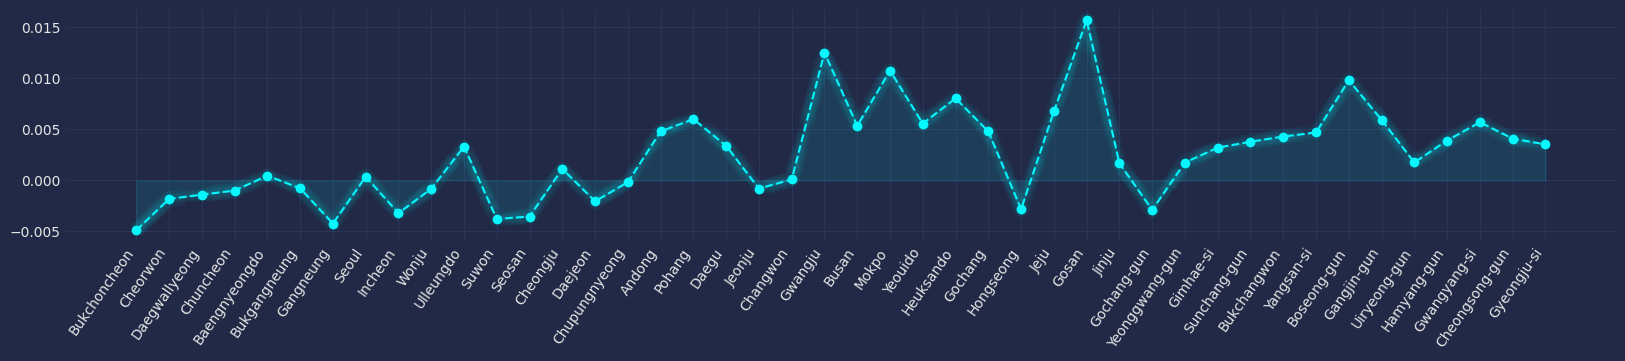

In [38]:
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(regions,classic.mean(axis=0)-proposed.mean(axis=0),'--o');
    plt.xticks(regions, rotation=55, ha='right');    
    mplcyberpunk.add_glow_effects()    

# <font color='green'>2. GConvLSTM</font>

In [5]:
from torch_geometric_temporal.nn.recurrent import GConvLSTM

In [6]:
# ?GConvLSTM

In [7]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvLSTM(in_channels = node_features, out_channels = filters, K = 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

In [8]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [9]:
class RGCN_Learner:
    def __init__(self,train_dataset,dataset_name = None):
        self.train_dataset = train_dataset
        self.lags = torch.tensor(train_dataset.features).shape[-1]
        self.dataset_name = str(train_dataset) if dataset_name is None else dataset_name
        self.method = 'RecurrentGCN'
    def learn(self,filters=32,epoch=50):
        self.model = RecurrentGCN(node_features=self.lags, filters=filters).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.model.train()
        for e in range(epoch):
            # self.h, self.c = None, None
            for snapshot in self.train_dataset:
                self.h, self.c = None, None
                snapshot = snapshot.to(device)
                yt_hat, self.h, self.c = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)
                # cost = cost + torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                cost = torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                cost.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            print('{}/{}'.format(e+1,epoch),end='\r')
        # recording HP
        self.nof_filters = filters
        # self.epochs = epoch+1
        self.epochs = epoch
    def __call__(self,dataset):
        X = torch.tensor(dataset.features).float()
        y = torch.tensor(dataset.targets).float()
        yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)[0] for snapshot in dataset]).detach().squeeze().float()
        return {'X':X, 'y':y, 'yhat':yhat} 

# learn 
def rgcn(FX,train_ratio,lags,filters,epoch):
    dct = makedict(FX=FX.tolist())
    loader = Loader(dct)
    dataset = loader.get_dataset(lags=lags)
    dataset_tr, dataset_test = eptstgcn.utils.temporal_signal_split(dataset, train_ratio = train_ratio)
    lrnr = RGCN_Learner(dataset_tr, dataset_name = 'org & arbitrary')
    lrnr.learn(filters=filters, epoch=epoch)
    yhat = np.array(lrnr(dataset)['yhat'])
    yhat = np.concatenate([np.array([list(yhat[0])]*lags),yhat],axis=0)
    return yhat

In [37]:
# hyper params
LAGS = 24
FILTERS = 8
EPOCH = 5

# global params
TRAIN_RATIO = 0.8
T,N = len(t),len(regions) 
LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
LEN_TR = T - LEN_TEST

In [38]:
# 방법1
yhat = rgcn(y,train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)
yhat[yhat < 0]= 0 

# 방법2 
yUhat = rgcn(yU,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS, epoch=EPOCH)

yPhat = rgcn(yP,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS, epoch=EPOCH)
yPhat[yPhat < 0] =0 


classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

5/5
total_mse(classic): 0.0701
total_mse(proposed): 0.1202


In [45]:
GConvLSTM_yhat = yhat
GConvLSTM_yUhat = yUhat
GConvLSTM_yPhat = yPhat

GConvLSTM_classic = ((y - yhat)[LEN_TR:, :] ** 2)
GConvLSTM_proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

`-` classic

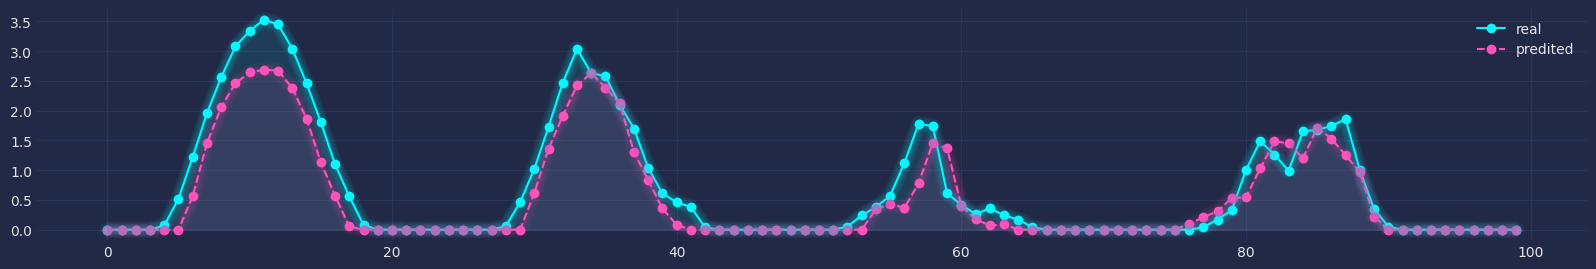

In [46]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot(GConvLSTM_yhat[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()

`-` yP vs. yPhat

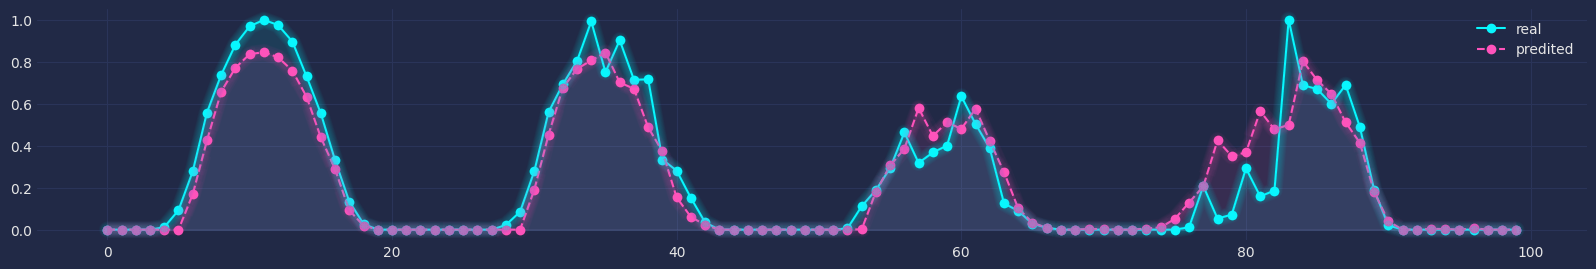

In [47]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yP[50:150,city],'o-',label='real')
    plt.plot(GConvLSTM_yPhat[50:150,city],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()   

`-` y vs (yUhat\*yPhat) \>\> proposed

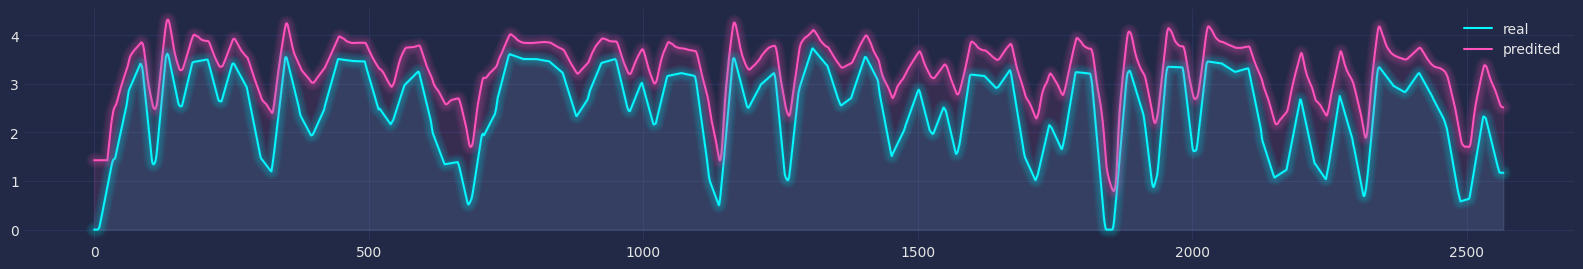

In [51]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yU[:,25],label='real')
    plt.plot(GConvLSTM_yUhat[:,25],label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

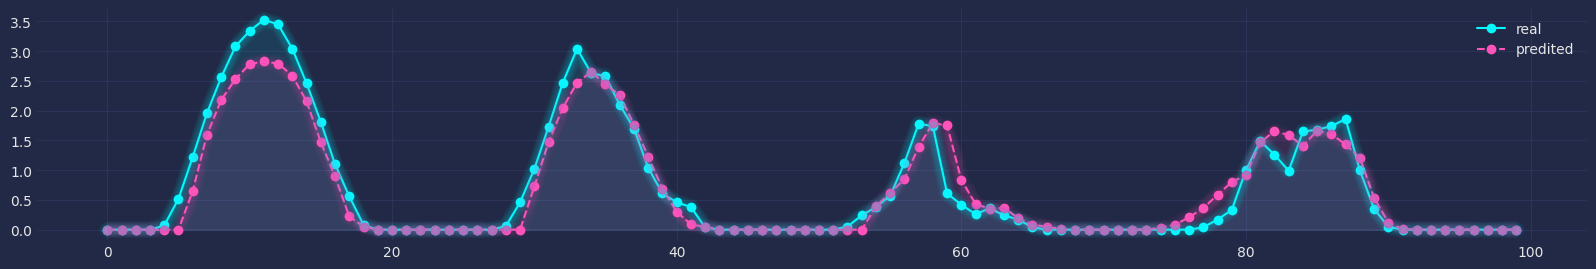

In [49]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot((GConvLSTM_yUhat*GConvLSTM_yPhat)[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` 지역별 분석

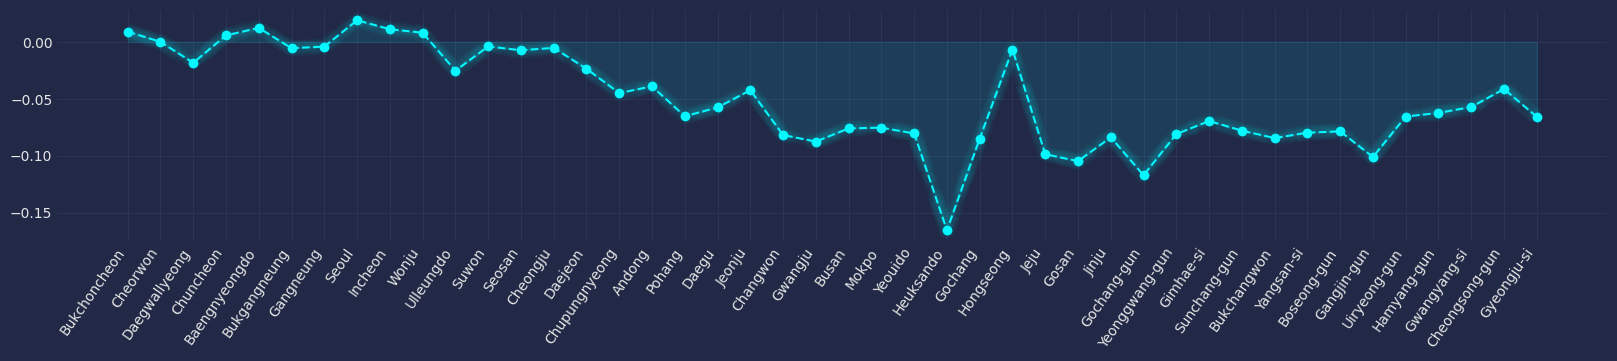

In [50]:
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(regions,GConvLSTM_classic.mean(axis=0)-GConvLSTM_proposed.mean(axis=0),'--o');
    plt.xticks(regions, rotation=55, ha='right');    
    mplcyberpunk.add_glow_effects()    

# <font color='orange'>3. GCLSTM</font>

In [174]:
from torch_geometric_temporal.nn.recurrent import GCLSTM

    GCLSTM(
        in_channels: int,
        out_channels: int,
        K: int,
        normalization: str = 'sym',
        bias: bool = True,

In [177]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GCLSTM(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

In [193]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [194]:
class RGCN_Learner:
    def __init__(self,train_dataset,dataset_name = None):
        self.train_dataset = train_dataset
        self.lags = torch.tensor(train_dataset.features).shape[-1]
        self.dataset_name = str(train_dataset) if dataset_name is None else dataset_name
        self.method = 'RecurrentGCN'
    def learn(self,filters=32,epoch=50):
        self.model = RecurrentGCN(node_features=self.lags, filters=filters).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.model.train()
        for e in range(epoch):
            # self.h, self.c = None, None
            for snapshot in self.train_dataset:
                self.h, self.c = None, None
                snapshot = snapshot.to(device)
                yt_hat, self.h, self.c = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)
                # cost = cost + torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                cost = torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                cost.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            print('{}/{}'.format(e+1,epoch),end='\r')
        # recording HP
        self.nof_filters = filters
        # self.epochs = epoch+1
        self.epochs = epoch
    def __call__(self,dataset):
        X = torch.tensor(dataset.features).float()
        y = torch.tensor(dataset.targets).float()
        yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)[0] for snapshot in dataset]).detach().squeeze().float()
        return {'X':X, 'y':y, 'yhat':yhat} 

# learn 
def rgcn(FX,train_ratio,lags,filters,epoch):
    dct = makedict(FX=FX.tolist())
    loader = Loader(dct)
    dataset = loader.get_dataset(lags=lags)
    dataset_tr, dataset_test = eptstgcn.utils.temporal_signal_split(dataset, train_ratio = train_ratio)
    lrnr = RGCN_Learner(dataset_tr, dataset_name = 'org & arbitrary')
    lrnr.learn(filters=filters, epoch=epoch)
    yhat = np.array(lrnr(dataset)['yhat'])
    yhat = np.concatenate([np.array([list(yhat[0])]*lags),yhat],axis=0)
    return yhat

In [195]:
# hyper params
LAGS = 4
FILTERS = 4
EPOCH = 30

In [197]:
# 방법1
yhat = rgcn(y,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)
yhat[yhat < 0]= 0 

# 방법2 
yUhat = rgcn(yU,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)

yPhat = rgcn(yP,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)
yPhat[yPhat < 0] =0 


classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

30/30
total_mse(classic): 0.2584
total_mse(proposed): 0.3364


In [202]:
GCLSTM_yhat = yhat
GCLSTM_yUhat = yUhat
GCLSTM_yPhat = yPhat

GCLSTM_classic = ((y - yhat)[LEN_TR:, :] ** 2)
GCLSTM_proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

`-` classic

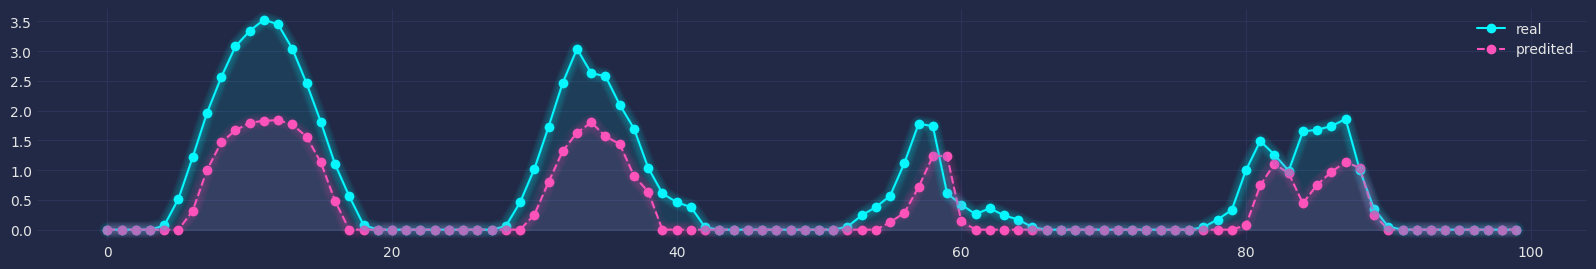

In [198]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot(GCLSTM_yhat[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()

`-` yP vs yPhat

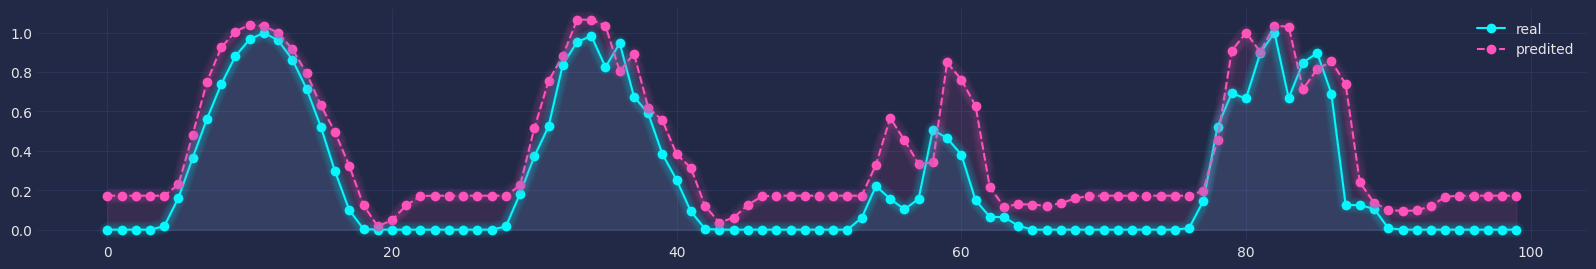

In [205]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yP[50:150,city],'o-',label='real')
    plt.plot(GCLSTM_yPhat[50:150,city],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` y vs (yUhat\*yPhat) \>\> proposed

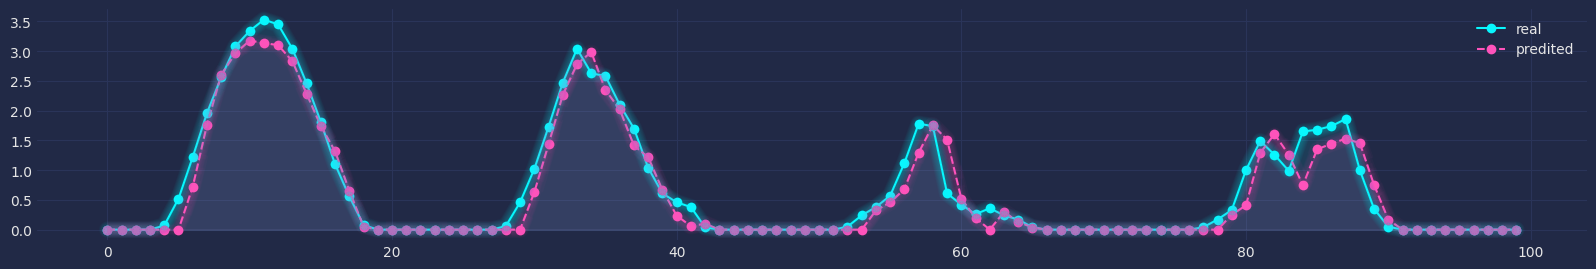

In [206]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot((GCLSTM_yUhat*GCLSTM_yPhat)[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` 지역별분석

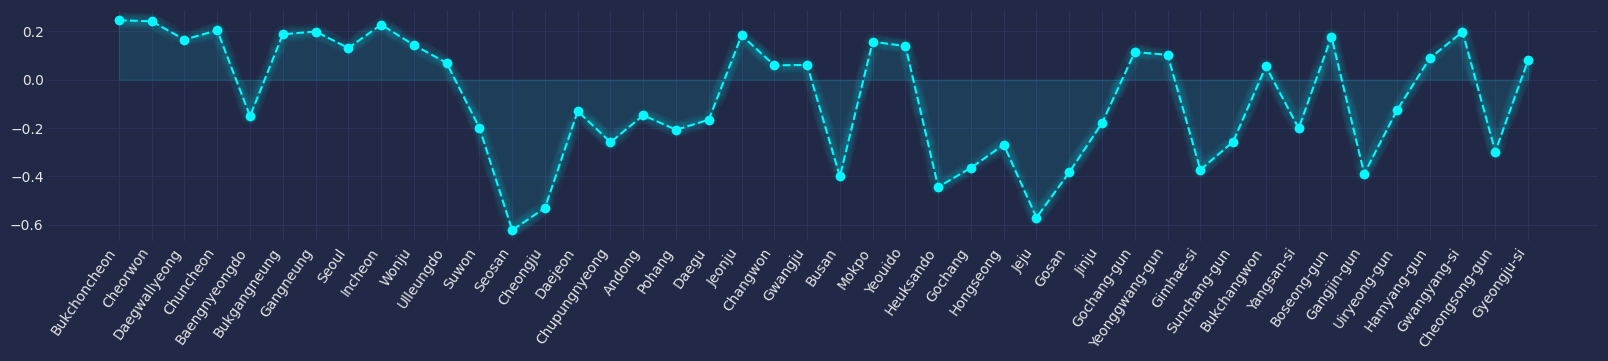

In [207]:
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(regions,GCLSTM_classic.mean(axis=0)-GCLSTM_proposed.mean(axis=0),'--o');
    plt.xticks(regions, rotation=55, ha='right');    
    mplcyberpunk.add_glow_effects()    

# <font color='orange'>4. LRGCN</font>

In [208]:
from torch_geometric_temporal.nn.recurrent import LRGCN

In [209]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = LRGCN(node_features, filters, 1, 1)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, h_0, c_0):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h_0, c_0)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

In [210]:
class RGCN_Learner:
    def __init__(self,train_dataset,dataset_name = None):
        self.train_dataset = train_dataset
        self.lags = torch.tensor(train_dataset.features).shape[-1]
        self.dataset_name = str(train_dataset) if dataset_name is None else dataset_name
        self.method = 'RecurrentGCN'
    def learn(self,filters=32,epoch=50):
        self.model = RecurrentGCN(node_features=self.lags, filters=filters).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.model.train()
        for e in range(epoch):
            for snapshot in self.train_dataset:
                self.h, self.c = None, None
                snapshot = snapshot.to(device)
                yt_hat, self.h, self.c = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)
                cost = torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                cost.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            print('{}/{}'.format(e+1,epoch),end='\r')
        # recording HP
        self.nof_filters = filters
        # self.epochs = epoch+1
        self.epochs = epoch
    def __call__(self,dataset):
        X = torch.tensor(dataset.features).float()
        y = torch.tensor(dataset.targets).float()
        yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)[0] for snapshot in dataset]).detach().squeeze().float()
        return {'X':X, 'y':y, 'yhat':yhat} 

# learn 
def rgcn(FX,train_ratio,lags,filters,epoch):
    dct = makedict(FX=FX.tolist())
    loader = Loader(dct)
    dataset = loader.get_dataset(lags=lags)
    dataset_tr, dataset_test = eptstgcn.utils.temporal_signal_split(dataset, train_ratio = train_ratio)
    lrnr = RGCN_Learner(dataset_tr, dataset_name = 'org & arbitrary')
    lrnr.learn(filters=filters, epoch=epoch)
    yhat = np.array(lrnr(dataset)['yhat'])
    yhat = np.concatenate([np.array([list(yhat[0])]*lags),yhat],axis=0)
    return yhat

In [211]:
# hyper params
LAGS = 4
FILTERS = 4
EPOCH = 30

In [212]:
# 방법1
yhat = rgcn(y,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)
yhat[yhat < 0]= 0 

# 방법2 
yUhat = rgcn(yU,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)

yPhat = rgcn(yP,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)
yPhat[yPhat < 0] =0 


classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

30/30
total_mse(classic): 0.4837
total_mse(proposed): 0.7375


In [213]:
LRGCN_yhat = yhat
LRGCN_yUhat = yUhat
LRGCN_yPhat = yPhat

LRGCN_classic = ((y - yhat)[LEN_TR:, :] ** 2)
LRGCN_proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

`-` classic

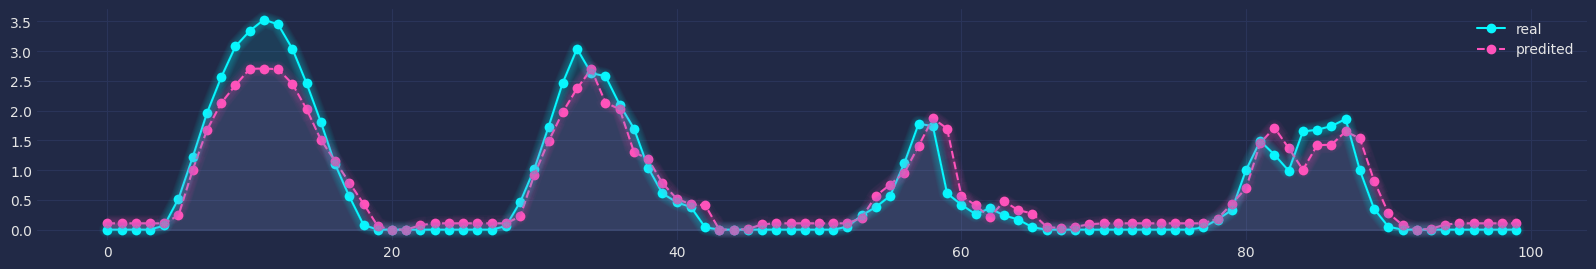

In [214]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot(LRGCN_yhat[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()

`-` yP vs yPhat

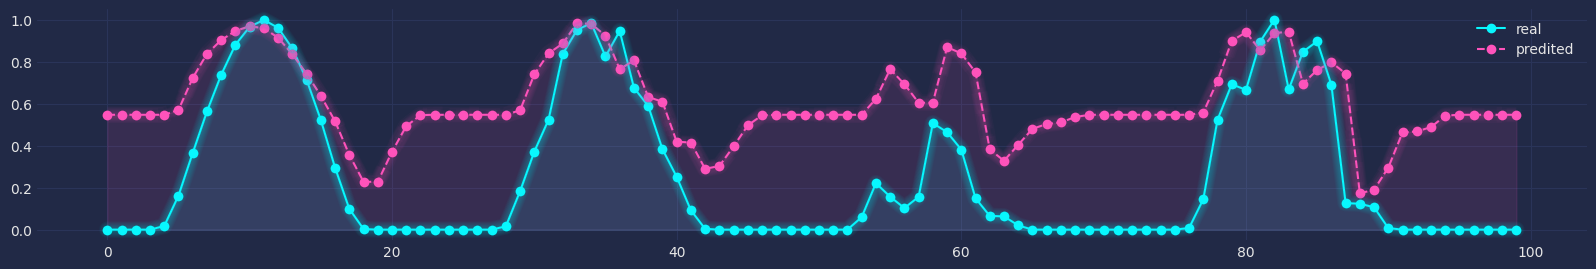

In [215]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yP[50:150,city],'o-',label='real')
    plt.plot(LRGCN_yPhat[50:150,city],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` y vs (yUhat\*yPhat) \>\> proposed

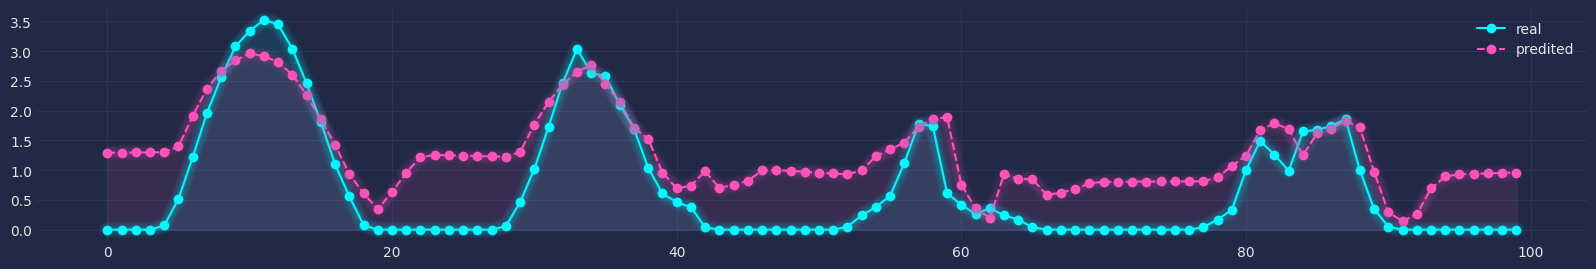

In [216]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot((LRGCN_yUhat*LRGCN_yPhat)[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` 지역별분석

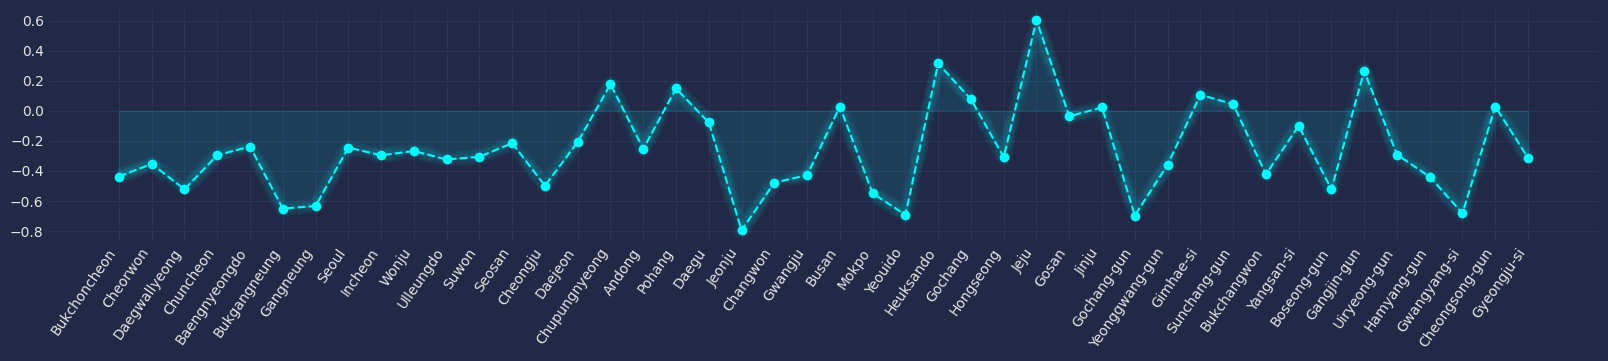

In [217]:
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(regions,LRGCN_classic.mean(axis=0)-LRGCN_proposed.mean(axis=0),'--o');
    plt.xticks(regions, rotation=55, ha='right');    
    mplcyberpunk.add_glow_effects()    

# <font color='orange'>5. TGCN</font>

An implementation of the Temporal Graph Convolutional Gated Recurrent
Cell.

-   paper: [“T-GCN: A Temporal Graph ConvolutionalNetwork for Traffic
    Prediction.”](https://arxiv.org/abs/1811.05320)

In [218]:
from torch_geometric_temporal.nn.recurrent import TGCN

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        improved (bool): Stronger self loops. Default is False.
        cached (bool): Caching the message weights. Default is False.
        add_self_loops (bool): Adding self-loops for smoothing. Default is True.

In [219]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = TGCN(node_features, filters)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, prev_hidden_state):
        h = self.recurrent(x, edge_index, edge_weight, prev_hidden_state)
        y = F.relu(h)
        y = self.linear(y)
        return y, h

In [222]:
class RGCN_Learner:
    def __init__(self,train_dataset,dataset_name = None):
        self.train_dataset = train_dataset
        self.lags = torch.tensor(train_dataset.features).shape[-1]
        self.dataset_name = str(train_dataset) if dataset_name is None else dataset_name
        self.method = 'RecurrentGCN'
    def learn(self,filters=32,epoch=50):
        self.model = RecurrentGCN(node_features=self.lags, filters=filters)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.model.train()
        for e in range(epoch):
            # self.hidden_state = None
            for snapshot in self.train_dataset:
                self.hidden_state = None
                # snapshot = snapshot.to(device)
                yt_hat, self.hidden_state = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.hidden_state)
                cost = torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                cost.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            print('{}/{}'.format(e+1,epoch),end='\r')
        # recording HP
        self.nof_filters = filters
        # self.epochs = epoch+1
        self.epochs = epoch
    def __call__(self,dataset):
        X = torch.tensor(dataset.features).float()
        y = torch.tensor(dataset.targets).float()
        yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr,self.hidden_state)[0] for snapshot in dataset]).detach().squeeze().float()
        return {'X':X, 'y':y, 'yhat':yhat} 

# learn 
def rgcn(FX,train_ratio,lags,filters,epoch):
    dct = makedict(FX=FX.tolist())
    loader = Loader(dct)
    dataset = loader.get_dataset(lags=lags)
    dataset_tr, dataset_test = eptstgcn.utils.temporal_signal_split(dataset, train_ratio = train_ratio)
    lrnr = RGCN_Learner(dataset_tr, dataset_name = 'org & arbitrary')
    lrnr.learn(filters=filters, epoch=epoch) ##
    yhat = np.array(lrnr(dataset)['yhat'])
    yhat = np.concatenate([np.array([list(yhat[0])]*lags),yhat],axis=0)
    return yhat

In [223]:
# hyper params
LAGS = 4
FILTERS = 4
EPOCH = 30

In [224]:
# 방법1
yhat = rgcn(y,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)
yhat[yhat < 0]= 0 

# 방법2 
yUhat = rgcn(yU,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)

yPhat = rgcn(yP,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)
yPhat[yPhat < 0] =0 


classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

30/30
total_mse(classic): 0.1371
total_mse(proposed): 0.1760


In [225]:
TGCN_yhat = yhat
TGCN_yUhat = yUhat
TGCN_yPhat = yPhat

TGCN_classic = ((y - yhat)[LEN_TR:, :] ** 2)
TGCN_proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

`-` classic

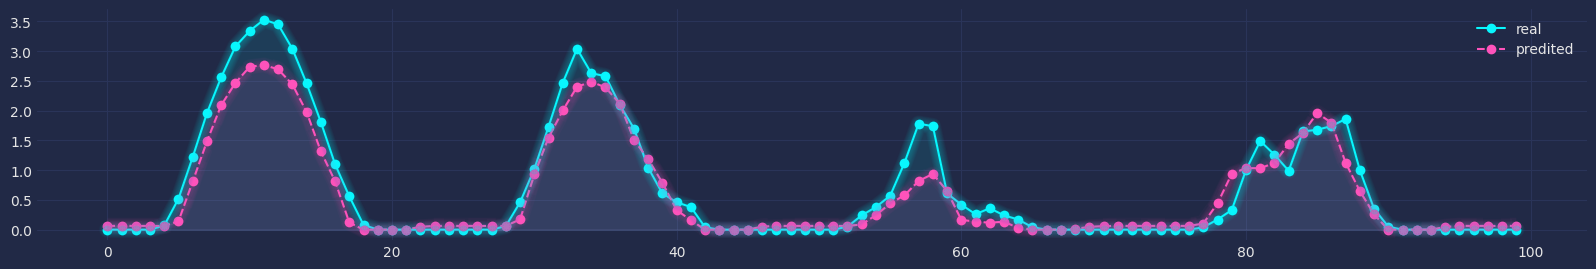

In [226]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot(TGCN_yhat[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()

`-` yP vs yPhat

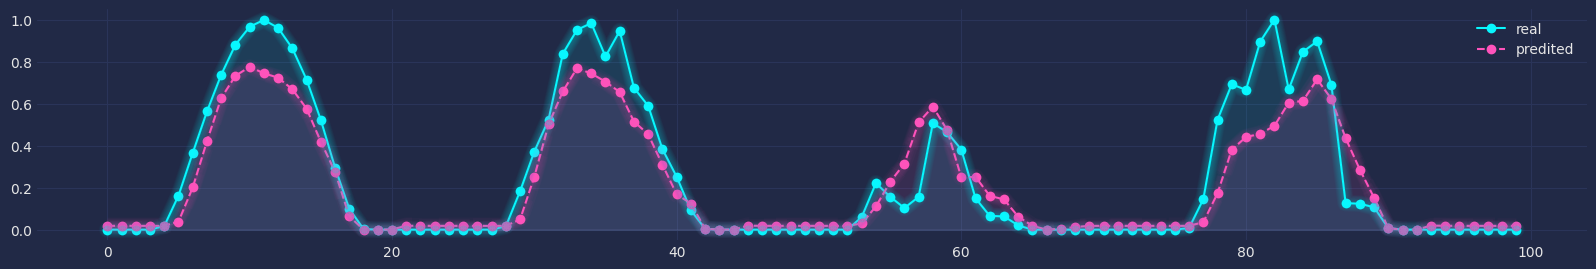

In [227]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yP[50:150,city],'o-',label='real')
    plt.plot(TGCN_yPhat[50:150,city],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` y vs (yUhat\*yPhat) \>\> proposed

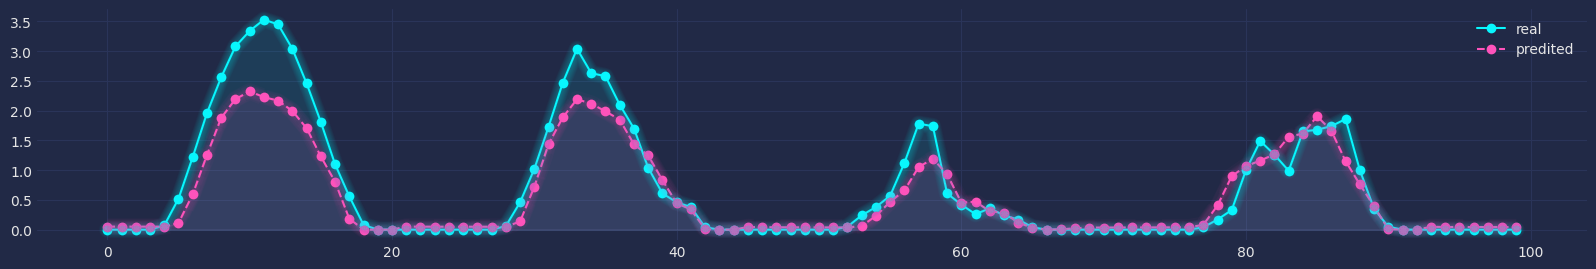

In [228]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot((TGCN_yUhat*TGCN_yPhat)[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` 지역별분석

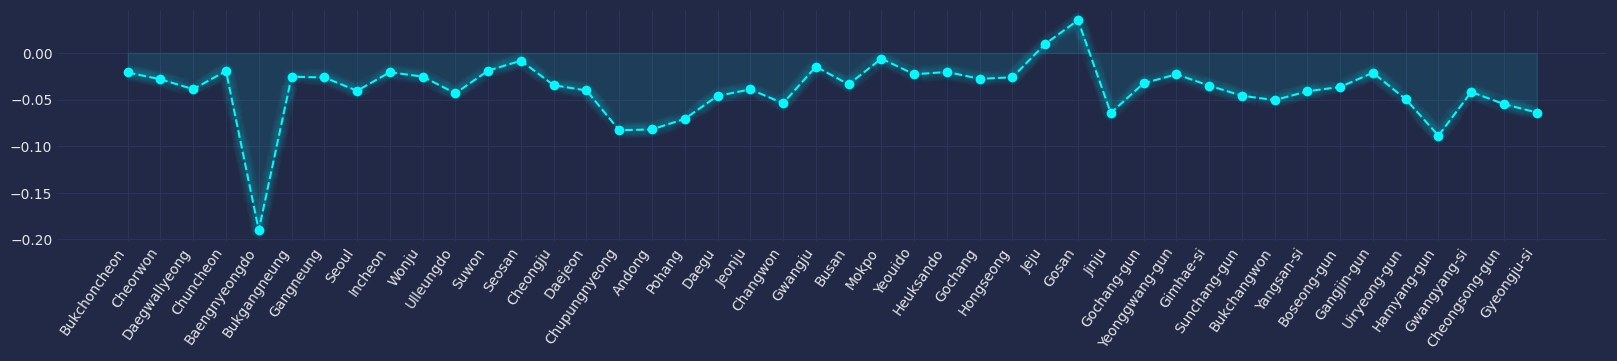

In [229]:
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(regions,TGCN_classic.mean(axis=0)-TGCN_proposed.mean(axis=0),'--o');
    plt.xticks(regions, rotation=55, ha='right');    
    mplcyberpunk.add_glow_effects()    

# 6. A3TGCN (에러남)

An implementation of the Attention Temporal Graph Convolutional Cell. -
paper: [“A3T-GCN: Attention Temporal Graph Convolutional Network for
Traffic Forecasting.”](https://arxiv.org/abs/2006.11583)

In [81]:
from torch_geometric_temporal.nn.recurrent import A3TGCN

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        periods (int): Number of time periods.
        improved (bool): Stronger self loops (default :obj:`False`).
        cached (bool): Caching the message weights (default :obj:`False`).
        add_self_loops (bool): Adding self-loops for smoothing (default :obj:`True`).

In [84]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters, periods):
        super(RecurrentGCN, self).__init__()
        self.recurrent = A3TGCN(node_features, filters, periods)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x.view(x.shape[0], 1, x.shape[1]), edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [96]:
class RGCN_Learner:
    def __init__(self,train_dataset,dataset_name = None):
        self.train_dataset = train_dataset
        self.lags = torch.tensor(train_dataset.features).shape[-1]
        self.dataset_name = str(train_dataset) if dataset_name is None else dataset_name
        self.method = 'RecurrentGCN'
    def learn(self,filters=32,periods=24, epoch=50):
        self.model = RecurrentGCN(node_features=self.lags, filters=filters, periods=periods)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.model.train()
        for e in range(epoch):
            cost = 0
            for t, snapshot in enumerate(self.train_dataset):
                yt_hat = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
                cost = cost + torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
            cost = cost / (t+1)
            cost.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            print('{}/{}'.format(e+1,epoch),end='\r')
        # recording HP
        self.nof_filters = filters
        # self.epochs = epoch+1
        self.epochs = epoch
    def __call__(self,dataset):
        X = torch.tensor(dataset.features).float()
        y = torch.tensor(dataset.targets).float()
        yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr) for snapshot in dataset]).detach().squeeze().float()
        return {'X':X, 'y':y, 'yhat':yhat} 

# learn 
def rgcn(FX,train_ratio,lags, filters, periods, epoch):
    dct = makedict(FX=FX.tolist())
    loader = Loader(dct)
    dataset = loader.get_dataset(lags=lags)
    dataset_tr, dataset_test = eptstgcn.utils.temporal_signal_split(dataset, train_ratio = train_ratio)
    lrnr = RGCN_Learner(dataset_tr, dataset_name = 'org & arbitrary')
    lrnr.learn(filters=filters, periods = periods, epoch=epoch)
    yhat = np.array(lrnr(dataset)['yhat'])
    yhat = np.concatenate([np.array([list(yhat[0])]*lags),yhat],axis=0)
    return yhat

In [97]:
# hyper params
LAGS = 1
FILTERS = 4
EPOCH = 1
PERIOD = 2

# global params
TRAIN_RATIO = 0.8
T,N = len(t),len(regions) 
LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
LEN_TR = T - LEN_TEST

In [98]:
# 방법1
yhat = rgcn(y,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS, periods = PERIOD, epoch=EPOCH)
yhat[yhat < 0]= 0 

# 방법2 
yUhat = rgcn(yU,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS, periods = PERIOD, epoch=EPOCH)

yPhat = rgcn(yP,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS, periods = PERIOD,epoch=EPOCH)
yPhat[yPhat < 0] =0 


classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

-   GPU로 뭘 올린적인 없는데 왜 cuda에러가 나는지..

# <font color='green'>7. DCRNN</font>

An implementation of the Diffusion Convolutional Gated Recurrent Unit -
paper: [“Diffusion Convolutional Recurrent Neural Network: Data-Driven
Traffic Forecasting”](https://arxiv.org/abs/1707.01926)

In [230]:
from torch_geometric_temporal.nn.recurrent import DCRNN

In [232]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [236]:
class RGCN_Learner:
    def __init__(self,train_dataset,dataset_name = None):
        self.train_dataset = train_dataset
        self.lags = torch.tensor(train_dataset.features).shape[-1]
        self.dataset_name = str(train_dataset) if dataset_name is None else dataset_name
        self.method = 'RecurrentGCN'
    def learn(self,filters=32, epoch=50):
        self.model = RecurrentGCN(node_features=self.lags, filters=filters)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.model.train()
        for e in range(epoch):
            for snapshot in self.train_dataset:
                yt_hat = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
                cost = torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                cost.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            print('{}/{}'.format(e+1,epoch),end='\r')
        # recording HP
        self.nof_filters = filters
        self.epochs = epoch
    def __call__(self,dataset):
        X = torch.tensor(dataset.features).float()
        y = torch.tensor(dataset.targets).float()
        yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr) for snapshot in dataset]).detach().squeeze().float()
        return {'X':X, 'y':y, 'yhat':yhat} 

# learn 
def rgcn(FX,train_ratio,lags, filters, epoch):
    dct = makedict(FX=FX.tolist())
    loader = Loader(dct)
    dataset = loader.get_dataset(lags=lags)
    dataset_tr, dataset_test = eptstgcn.utils.temporal_signal_split(dataset, train_ratio = train_ratio)
    lrnr = RGCN_Learner(dataset_tr, dataset_name = 'org & arbitrary')
    lrnr.learn(filters=filters, epoch=epoch)
    yhat = np.array(lrnr(dataset)['yhat'])
    yhat = np.concatenate([np.array([list(yhat[0])]*lags),yhat],axis=0)
    return yhat

In [237]:
# hyper params
LAGS = 4
FILTERS = 4
EPOCH = 30

In [238]:
# 방법1
yhat = rgcn(y,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS, epoch=EPOCH)
yhat[yhat < 0]= 0 

# 방법2 
yUhat = rgcn(yU,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS, epoch=EPOCH)

yPhat = rgcn(yP,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS, epoch=EPOCH)
yPhat[yPhat < 0] =0 


classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

30/30
total_mse(classic): 0.0545
total_mse(proposed): 0.0514


In [239]:
DCRNN_yhat = yhat
DCRNN_yUhat = yUhat
DCRNN_yPhat = yPhat

DCRNN_classic = ((y - yhat)[LEN_TR:, :] ** 2)
DCRNN_proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

`-` classic

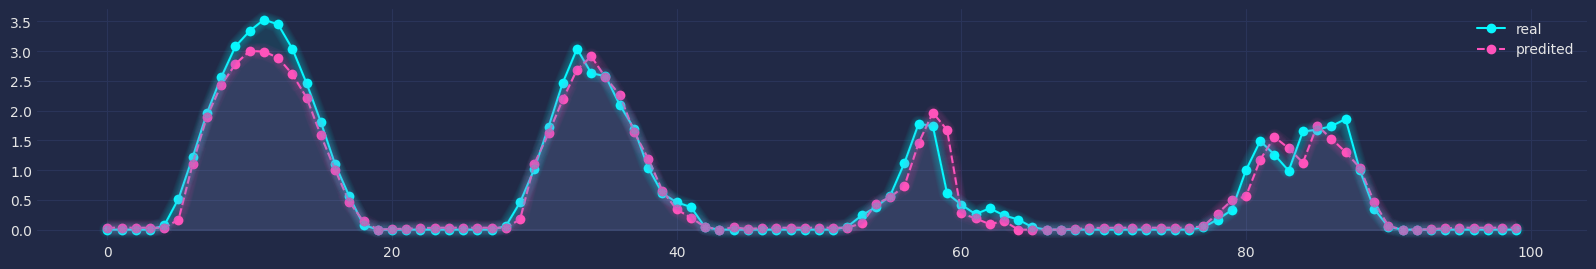

In [240]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot(DCRNN_yhat[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()

`-` yP vs yPhat

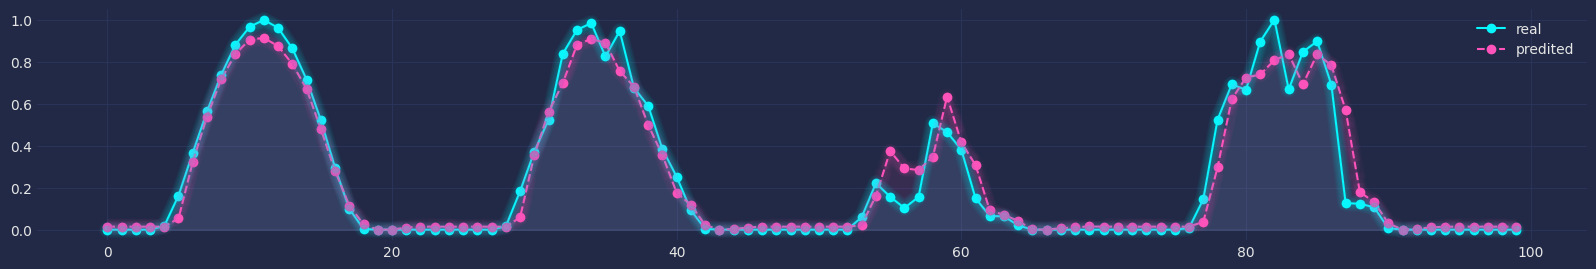

In [241]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yP[50:150,city],'o-',label='real')
    plt.plot(DCRNN_yPhat[50:150,city],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` y vs (yUhat\*yPhat) \>\> proposed

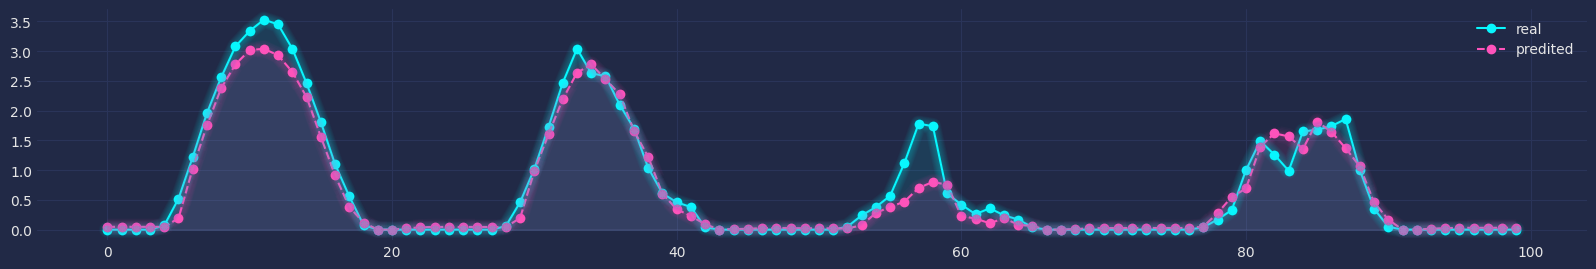

In [242]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot((DCRNN_yUhat*DCRNN_yPhat)[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` 지역별분석

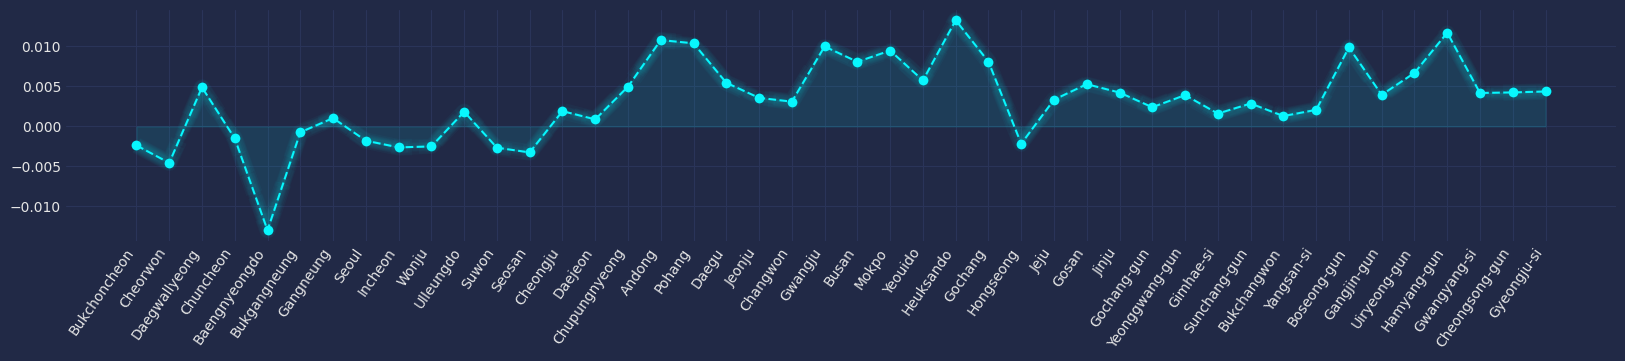

In [243]:
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(regions,DCRNN_classic.mean(axis=0)-DCRNN_proposed.mean(axis=0),'--o');
    plt.xticks(regions, rotation=55, ha='right');    
    mplcyberpunk.add_glow_effects()    

# 8. STGCN (보류)

-   ref:
    <https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/root.html>
-   ref: <https://github.com/FelixOpolka/STGCN-PyTorch/tree/master>

In [106]:
from torch_geometric_temporal.nn.attention import STConv

In [107]:
?STConv

In [108]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import ChebConv


class TemporalConv(nn.Module):
    r"""Temporal convolution block applied to nodes in the STGCN Layer
    For details see: `"Spatio-Temporal Graph Convolutional Networks:
    A Deep Learning Framework for Traffic Forecasting."
    <https://arxiv.org/abs/1709.04875>`_ Based off the temporal convolution
     introduced in "Convolutional Sequence to Sequence Learning"  <https://arxiv.org/abs/1709.04875>`_

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        kernel_size (int): Convolutional kernel size.
    """

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3):
        super(TemporalConv, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv_2 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv_3 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))

    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        """Forward pass through temporal convolution block.

        Arg types:
            * **X** (torch.FloatTensor) -  Input data of shape
                (batch_size, input_time_steps, num_nodes, in_channels).

        Return types:
            * **H** (torch.FloatTensor) - Output data of shape
                (batch_size, in_channels, num_nodes, input_time_steps).
        """
        X = X.permute(0, 3, 2, 1)
        P = self.conv_1(X)
        Q = torch.sigmoid(self.conv_2(X))
        PQ = P * Q
        H = F.relu(PQ + self.conv_3(X))
        H = H.permute(0, 3, 2, 1)
        return H



class STConv(nn.Module):
    r"""Spatio-temporal convolution block using ChebConv Graph Convolutions.
    For details see: `"Spatio-Temporal Graph Convolutional Networks:
    A Deep Learning Framework for Traffic Forecasting"
    <https://arxiv.org/abs/1709.04875>`_

    NB. The ST-Conv block contains two temporal convolutions (TemporalConv)
    with kernel size k. Hence for an input sequence of length m,
    the output sequence will be length m-2(k-1).

    Args:
        in_channels (int): Number of input features.
        hidden_channels (int): Number of hidden units output by graph convolution block
        out_channels (int): Number of output features.
        kernel_size (int): Size of the kernel considered.
        K (int): Chebyshev filter size :math:`K`.
        normalization (str, optional): The normalization scheme for the graph
            Laplacian (default: :obj:`"sym"`):

            1. :obj:`None`: No normalization
            :math:`\mathbf{L} = \mathbf{D} - \mathbf{A}`

            2. :obj:`"sym"`: Symmetric normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{A}
            \mathbf{D}^{-1/2}`

            3. :obj:`"rw"`: Random-walk normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1} \mathbf{A}`

            You need to pass :obj:`lambda_max` to the :meth:`forward` method of
            this operator in case the normalization is non-symmetric.
            :obj:`\lambda_max` should be a :class:`torch.Tensor` of size
            :obj:`[num_graphs]` in a mini-batch scenario and a
            scalar/zero-dimensional tensor when operating on single graphs.
            You can pre-compute :obj:`lambda_max` via the
            :class:`torch_geometric.transforms.LaplacianLambdaMax` transform.
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)

    """

    def __init__(
        self,
        num_nodes: int,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        kernel_size: int,
        K: int,
        normalization: str = "sym",
        bias: bool = True,
    ):
        super(STConv, self).__init__()
        self.num_nodes = num_nodes
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.K = K
        self.normalization = normalization
        self.bias = bias

        self._temporal_conv1 = TemporalConv(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size,
        )

        self._graph_conv = ChebConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels,
            K=K,
            normalization=normalization,
            bias=bias,
        )

        self._temporal_conv2 = TemporalConv(
            in_channels=hidden_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
        )

        self._batch_norm = nn.BatchNorm2d(num_nodes)

    def forward(
        self,
        X: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
    ) -> torch.FloatTensor:

        r"""Forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph.

        Arg types:
            * **X** (PyTorch FloatTensor) - Sequence of node features of shape (Batch size X Input time steps X Num nodes X In channels).
            * **edge_index** (PyTorch LongTensor) - Graph edge indices.
            * **edge_weight** (PyTorch LongTensor, optional)- Edge weight vector.

        Return types:
            * **T** (PyTorch FloatTensor) - Sequence of node features.
        """
        T_0 = self._temporal_conv1(X)
        T = torch.zeros_like(T_0).to(T_0.device)
        for b in range(T_0.size(0)):
            for t in range(T_0.size(1)):
                T[b][t] = self._graph_conv(T_0[b][t], edge_index, edge_weight)

        T = F.relu(T)
        T = self._temporal_conv2(T)
        T = T.permute(0, 2, 1, 3)
        T = self._batch_norm(T)
        T = T.permute(0, 2, 1, 3)
        return T

------------------------------------------------------------------------

# $\star$ Summary

`-` Experimenting settings

-   lag=4, filter=4, epoch=30

Using $80\%$ of the temporal snapshots for training, we evaluated the
forecasting performance on the last 20$\%$ by calculating the average
mean squared error from 1 experimental runs.

We used models with a recurrent graph convolutional layer which had 4
convolutional filters. The spatiotemporal layer was followed by the
rectified linear unit activation function.

The hidden representations were fed to a fully connected feedforward
layer which outputted the predicted scores for each spatial unit.

The recurrent models were trained for $30$ epochs with the Adam
optimizer which used a learning rate of $10^{-2}$. (to minimize the mean
squared error. \<– 이부분은 시뮬레이션 해보고 성능 좋은 세팅으로 맞춘
후에 써야지.)

|                  model                   | classic_mse | proposed_mse | note   |
|:----------------------------------------:|:-----------:|:------------:|--------|
| **<font color='green'>GConvGRU</font>**  |  $0.0545$   |   $0.0521$   | 굳     |
| **<font color='green'>GConvLSTM</font>** |  $0.3867$   |   $0.1223$   |        |
|   **<font color='green'>DCRNN</font>**   |  $0.0545$   |   $0.0514$   | 굳     |
|  **<font color='orange'>GCLSTM</font>**  |  $0.2584$   |   $0.3364$   |        |
|  **<font color='orange'>LRGCN</font>**   |  $0.4837$   |   $0.7375$   | 쓰레기 |
|   **<font color='orange'>TGCN</font>**   |  $0.1371$   |   $0.1760$   |        |

-   lag=4, filter=4, epoch=30 에서의 세팅에서 6개의 모델을 MSE를 평가
    기준으로 하여 비교한 결과이다. GConvGRU, GConvLSTM, DCRNN에서 우리가
    제안한 방법의 성능이 더 좋았으며, 그 중 특히 GConvGRU, DCRNN에서
    좋은 성능을 보인다. (GConvGRU, DCRNN 등 일부 모델에서 Dropout 층을
    추가하면 더 좋은 결과가 나온다.)

-   각 시간 스냅샷 후 loss가 역전파되고 가중치가 업데이트 되는
    incremental backpropagation 전략을 사용하였다. 에폭당 한번의
    가중치가 업데이트되는 cummulative backpropagation strategy은
    recurrent graph neural network의 예측 성능에 안좋은 영향이 있었다.
    (에폭을 많이 늘리면(200정도) 좋아지긴 하지만 시간이 너무 많이 걸려
    효율성 면에서 떨어지는 것 같다.)

# ref (오류해결)

-   <https://stackoverflow.com/questions/46774641/what-does-the-parameter-retain-graph-mean-in-the-variables-backward-method?fbclid=IwAR24rnik7Q5L5dx5OXOhagL3iJR8efWhEf8J8mVeOB0cPCYekamAlgCiMGc>

-   <https://discuss.pytorch.org/t/runtimeerror-trying-to-backward-through-the-graph-a-second-time-but-the-buffers-have-already-been-freed-specify-retain-graph-true-when-calling-backward-the-first-time/6795/62>